In [1]:
import glob

import tensorflow as tf
import numpy as np
import pandas as pd
import cv2
import imutils
import random
from tensorflow import keras
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input,Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization, ZeroPadding2D,MaxPool2D,SeparableConv2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from IPython.display import Image



In [2]:
PATH = './chest_xray/'

TRAIN_DATA_DIR = PATH + 'train'
TEST_DATA_DIR = PATH + 'test'
VAL_DATA_DIR = PATH + 'val'


TRAIN_DATA_NORMAL_FILE = PATH + 'train/NORMAL/'
TRAIN_DATA_PNEUMONIA_FILE = PATH + 'train/PNEUMONIA/'
VAL_DATA_NORMAL_FILE = PATH + 'val/NORMAL/'
VAL_DATA_PNEUMONIA_FILE = PATH + 'val/PNEUMONIA/'
TEST_DATA_NORMAL_FILE = PATH + 'test/NORMAL/'
TEST_DATA_PNEUMONIA_FILE = PATH + 'test/PNEUMONIA/'

IMAGE_SIZE = (256,256)
BATCH_SIZE = 32
EPOCHS = 10


train_data_normal = glob.glob(TRAIN_DATA_NORMAL_FILE + '*jpeg')
train_data_pneumonia = glob.glob(TRAIN_DATA_PNEUMONIA_FILE + '*jpeg')
val_data_normal = glob.glob(VAL_DATA_NORMAL_FILE + '*jpeg')
val_data_pneumonia = glob.glob(VAL_DATA_PNEUMONIA_FILE + '*jpeg')
test_data_normal = glob.glob(TEST_DATA_NORMAL_FILE + '*jpeg')
test_data_pneumonia = glob.glob(TEST_DATA_PNEUMONIA_FILE + '*jpeg')

In [3]:
train_data_generator = ImageDataGenerator(rescale = 1/255)

test_data_generator = ImageDataGenerator(rescale = 1/255)

In [4]:

train_generator = train_data_generator.flow_from_directory(
        TRAIN_DATA_DIR,
        target_size = IMAGE_SIZE,
        batch_size = BATCH_SIZE,
        class_mode = 'binary')

test_generator = test_data_generator.flow_from_directory(
        VAL_DATA_DIR,
        target_size = IMAGE_SIZE,
        batch_size = BATCH_SIZE,
        class_mode = 'binary')

Found 6788 images belonging to 2 classes.
Found 1172 images belonging to 2 classes.


In [5]:
model = tf.keras.models.Sequential([

    tf.keras.layers.Conv2D(8, (3,3), padding='same', activation='relu', input_shape=(256,256,3)),
    #tf.keras.layers.Conv2D(8, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(3,3),
    
    # CNN Layer 1
    tf.keras.layers.Conv2D(16, (3,3), padding='same', activation='relu'),
    #tf.keras.layers.Conv2D(16, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPool2D(3,3),
    # CNN Layer 2
    tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    #tf.keras.layers.Conv2D(32, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # CNN Layer 3
    tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    #tf.keras.layers.Conv2D(64, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    # CNN Layer 4
    tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    #tf.keras.layers.Conv2D(128, (3,3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),


    # Layer 6
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 85, 85, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 85, 85, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 28, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        4640      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 64)        1

In [6]:
from tensorflow.keras.optimizers import RMSprop
model.compile(loss='binary_crossentropy',optimizer=RMSprop(lr=0.0001),metrics=['accuracy'])

In [7]:
class_weights = class_weight.compute_class_weight(
           'balanced',
            np.unique(train_generator.classes), 
            train_generator.classes)


/Users/kolevak/opt/miniconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:70: FutureWarning: Pass classes=[0 1], y=[0 0 0 ... 1 1 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [8]:

checkpoint = ModelCheckpoint('Pneumonia_new_dataset444.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='auto')
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')

history=model.fit(train_generator, 
                  epochs = EPOCHS, 
                  validation_data = test_generator, 
                  callbacks=[checkpoint,lr_reduce])

Epoch 1/10
213/213 [==============================] - 129s 604ms/step - loss: 0.5872 - accuracy: 0.6881 - val_loss: 0.4193 - val_accuracy: 0.7969

Epoch 00001: val_loss improved from inf to 0.41926, saving model to Pneumonia_new_dataset444.h5
Epoch 2/10
213/213 [==============================] - 135s 635ms/step - loss: 0.2896 - accuracy: 0.8858 - val_loss: 0.1743 - val_accuracy: 0.9437

Epoch 00002: val_loss improved from 0.41926 to 0.17434, saving model to Pneumonia_new_dataset444.h5
Epoch 3/10
213/213 [==============================] - 129s 606ms/step - loss: 0.2077 - accuracy: 0.9234 - val_loss: 0.1991 - val_accuracy: 0.9215

Epoch 00003: val_loss did not improve from 0.17434

Epoch 00003: ReduceLROnPlateau reducing learning rate to 2.9999999242136255e-05.
Epoch 4/10
213/213 [==============================] - 117s 550ms/step - loss: 0.1741 - accuracy: 0.9410 - val_loss: 0.1380 - val_accuracy: 0.9556

Epoch 00004: val_loss improved from 0.17434 to 0.13799, saving model to Pneumonia_n

In [9]:
model.save("pneumonia_model222.h5")

<Figure size 432x288 with 0 Axes>

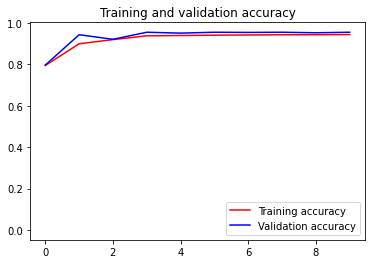

<Figure size 432x288 with 0 Axes>

In [10]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


epochs = range(len(acc))

plt.plot(range(0, 1))
plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()


In [11]:
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model

def load_image(filename):
	# load the image
	img = load_img(filename, target_size=IMAGE_SIZE)
	# convert to array
	img = img_to_array(img)
	# reshape into a single sample with 3 channels
	img = img.reshape(1,256,256, 3)
	# center pixel data
	img = img.astype('float32')
	return img

In [57]:

test_generator = test_data_generator.flow_from_directory(
        TEST_DATA_DIR,
        target_size = IMAGE_SIZE,
        batch_size = BATCH_SIZE,
        class_mode = 'binary')

model2 = tf.keras.models.load_model('Pneumonia_new_dataset444-Copy1.h5')

test_generator.class_indices
result = model2.evaluate(test_generator)

Found 586 images belonging to 2 classes.
19/19 [==============================] - 8s 413ms/step - loss: 0.1631 - accuracy: 0.9403


In [13]:
normal_test_data = glob.glob('db2/train/NORMAL/*')
pneumonia_test_data = glob.glob('db2/train/PNEUMONIA/*')

test_df = []
for elem in normal_test_data:
    test_df.append([elem,0])
    
for elem in pneumonia_test_data:
    test_df.append([elem,1])
    
random.shuffle(test_df)

In [47]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
preprocess_input = tf.keras.applications.xception.preprocess_input
decode_predictions = tf.keras.applications.xception.decode_predictions

def find_target_layer(model):
    for layer in reversed(model.layers):

            # check to see if the layer has a 4D output
        if len(layer.output_shape) == 4:
            return layer.name


def get_img_array(img_path, size):
    # `img` is a PIL image of size 299x299
    img = keras.preprocessing.image.load_img(img_path, target_size=size)
    # `array` is a float32 Numpy array of shape (299, 299, 3)
    array = keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size (1, 299, 299, 3)
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(
    img_array, model, last_conv_layer_name, classifier_layer_names
):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer
    last_conv_layer = model.get_layer(last_conv_layer_name)
    last_conv_layer_model = keras.Model(model.inputs, last_conv_layer.output)

    # Second, we create a model that maps the activations of the last conv
    # layer to the final class predictions
    classifier_input = keras.Input(shape=last_conv_layer.output.shape[1:])
    x = classifier_input
    for layer_name in classifier_layer_names:
        x = model.get_layer(layer_name)(x)
    classifier_model = keras.Model(classifier_input, x)

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        # Compute activations of the last conv layer and make the tape watch it
        last_conv_layer_output = last_conv_layer_model(img_array)
        tape.watch(last_conv_layer_output)
        # Compute class predictions
        preds = classifier_model(last_conv_layer_output)
        top_pred_index = tf.argmax(preds[0])
        top_class_channel = preds[:, top_pred_index]

    # This is the gradient of the top predicted class with regard to
    # the output feature map of the last conv layer
    grads = tape.gradient(top_class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    last_conv_layer_output = last_conv_layer_output.numpy()[0]
    pooled_grads = pooled_grads.numpy()
    for i in range(pooled_grads.shape[-1]):
        last_conv_layer_output[:, :, i] *= pooled_grads[i]

    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(last_conv_layer_output, axis=-1)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = np.maximum(heatmap, 0) / np.max(heatmap)
    return heatmap


Predict: [1.] Actual: 1


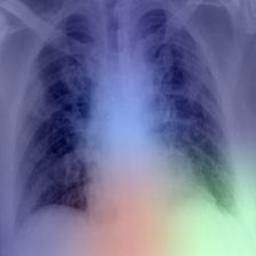

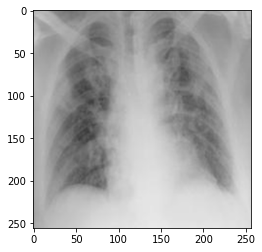

In [53]:

classifier_layer_names = [
    'flatten',
    'dense',
    'dense_1'
]

# Print what the top predicted class is
# 156 160 168 20 21 23 24 25 30 33 36 38 40 43
pick = pneumonia_test_data[20]
image = load_image(pick)
preds = model2.predict(image)
plt.imshow(cv2.imread(pick))
img_array = preprocess_input(get_img_array(pick, size=IMAGE_SIZE))


preds = model2.predict(image)
i = np.argmax(preds[0])
print("Predict: {} Actual: {}".format(preds[0],1))
#print("Predicted:", decode_predictions(preds, top=1)[0])

# Generate class activation heatmap
heatmap = make_gradcam_heatmap(
    img_array, model2, find_target_layer(model2), classifier_layer_names
)

# Display heatmap
# plt.matshow(heatmap)
# plt.show()

img = keras.preprocessing.image.load_img(pick)
img = keras.preprocessing.image.img_to_array(img)

# We rescale heatmap to a range 0-255
heatmap = np.uint8(255 * heatmap)

# We use jet colormap to colorize heatmap
jet = cm.get_cmap("jet")

# We use RGB values of the colormap
jet_colors = jet(np.arange(256))[:, :3]
jet_heatmap = jet_colors[heatmap]

# We create an image with RGB colorized heatmap
jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

# Superimpose the heatmap on original image
superimposed_img = jet_heatmap * 0.4 + img
superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

# Save the superimposed image
save_path = "elephant_cam.jpg"
superimposed_img.save(save_path)

# Display Grad CAM
display(Image(save_path))